In [1]:
! pip install transformers
! pip install tensorflow==2.3.0
import tensorflow as tf
from transformers import RobertaConfig, AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification
# import tensorflow as tf
tf.config.list_physical_devices('GPU')

     |████████████████████████████████| 3.1 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 85.8 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 50.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
     |███████████████████████████▉    | 279.0 MB 55.6 MB/s eta 0:00:011  |████████▋                       | 86.4 MB 4.5 MB/s eta 0:00:53     |██████████████▍                 | 144.0 MB 103.8 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 320.4 MB 43 kB/s 
     |████████████████████████████████| 20.1 MB 120.9 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 118.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.4
    Uninstalling tensorflow-2.3.4:
      Successfully uninstalled tensorflow-2.3.4
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Check tensorflow version
tf.__version__

'2.3.0'

In [3]:
import numpy as np
import pandas as pd
import argparse
import logging
import os
import sys
import csv
import s3fs
import json
import re
import gc
import scipy.stats as st
from sklearn.metrics import precision_recall_curve


fs = s3fs.S3FileSystem()
MAX_LEN = 128
PEACE_COUNTRY = set(['Australia', 'New Zealand', 
                 'Belgium', 'Sweden', 'Denmark', 
                 'Norway', 'Finland', 'Czech Republic', 
                 'Netherlands', 'Austria'])
MAJOR_COUNTRY = set(['Australia', 'India'])

In [4]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
config = RobertaConfig.from_pretrained(
    'roberta-base',
    num_labels=1, #Binary Classification
    dropout=0.1,
    attention_dropout=0.1,
    output_hidden_states=False,
    output_attentions=False
)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [5]:
# Define encoding function parser
def regular_encode(texts, tokenizer, maxlen=MAX_LEN):
    """
    Function to encode the word
    """
    # encode the word to vector of integer
    enc_di = tokenizer.encode_plus(
        texts, 
        return_attention_mask=True, 
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        max_length=maxlen)
    
    return np.array(enc_di['input_ids']), np.array(enc_di['attention_mask'])

## Load Unshuffled, Original Data

In [6]:
# Load in data
train_count = 0  
val_count = 0  
train_label_counter = [0, 0]
val_label_counter = [0, 0]

train_label_count_max = 4e4 
val_label_count_max = 1e4 
total_train = 2 * train_label_count_max
total_val = 2 * val_label_count_max

X_train = []
y_train = []

X_val = []
y_val = []

for line in fs.open('s3://compressed-data-sample/processed_train.json'):
    if train_count >= total_train and val_count >= total_val:
        break
    json_file = json.loads(line)
    country = json_file['country']
    label =  int(json_file['country'] in PEACE_COUNTRY)
    
    if not country in MAJOR_COUNTRY:
        if train_label_counter[label] < train_label_count_max :
            sent = json_file['content_cleaned']
            ids, msk = regular_encode(sent, tokenizer) # tokenize content_cleaned
            
            X_train.append({'input_ids': ids,'attention_mask':msk})
            y_train.append(label)
            train_count += 1
            train_label_counter[label] += 1
            if sum(train_label_counter) % 1e3 == 0:
                print('Train', train_label_counter)
    else:
        if val_label_counter[label] < val_label_count_max :
            sent = json_file['content_cleaned']
            ids, msk = regular_encode(sent, tokenizer) # tokenize content_cleaned
            
            X_val.append({'input_ids': ids,'attention_mask':msk})
            y_val.append(label)
            val_count += 1
            val_label_counter[label] += 1
            if sum(val_label_counter) % 1e3 == 0:
                print('Val', val_label_counter)

Val [532, 468]
Val [1065, 935]
Val [1607, 1393]
Val [2144, 1856]
Val [2690, 2310]
Train [240, 760]
Val [3255, 2745]
Val [3805, 3195]
Val [4348, 3652]
Val [4906, 4094]
Val [5457, 4543]
Train [481, 1519]
Val [5984, 5016]
Val [6519, 5481]
Val [7059, 5941]
Val [7638, 6362]
Val [8191, 6809]
Train [749, 2251]
Val [8747, 7253]
Val [9315, 7685]
Val [9837, 8163]
Val [10000, 9000]
Train [1028, 2972]
Val [10000, 10000]
Train [1268, 3732]
Train [1522, 4478]
Train [1770, 5230]
Train [2027, 5973]
Train [2301, 6699]
Train [2562, 7438]
Train [2796, 8204]
Train [3071, 8929]
Train [3327, 9673]
Train [3601, 10399]
Train [3863, 11137]
Train [4128, 11872]
Train [4384, 12616]
Train [4619, 13381]
Train [4861, 14139]
Train [5101, 14899]
Train [5352, 15648]
Train [5588, 16412]
Train [5843, 17157]
Train [6113, 17887]
Train [6353, 18647]
Train [6634, 19366]
Train [6926, 20074]
Train [7193, 20807]
Train [7450, 21550]
Train [7714, 22286]
Train [7969, 23031]
Train [8237, 23763]
Train [8478, 24522]
Train [8739, 2526

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_all = np.hstack([X_train, X_val])
y_all = np.hstack([y_train, y_val])

## Prepare for model training

In [8]:
from sklearn.model_selection import StratifiedKFold

def get_model(lr = 3e-5):
    bert_model = TFAutoModelForSequenceClassification.from_pretrained('roberta-base', trainable=True, config=config)
    input_ids_in = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_ids', dtype='int32')
    input_masks_ids_in = tf.keras.layers.Input(shape=(MAX_LEN,), name='attention_mask', dtype='int32')
    output_layer = bert_model(input_ids_in, input_masks_ids_in)[0]
    output_layer = tf.keras.layers.Activation(activation='sigmoid')(output_layer)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_ids_in], outputs = output_layer)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
               tf.keras.metrics.Precision(name='precision', thresholds=0.5),
               tf.keras.metrics.Recall(name='recall', thresholds=0.5),
               tf.keras.metrics.TruePositives(name='TP', thresholds=0.5),
               tf.keras.metrics.TrueNegatives(name='TN', thresholds=0.5),
               tf.keras.metrics.FalsePositives(name='FP', thresholds=0.5),
               tf.keras.metrics.FalseNegatives(name='FN', thresholds=0.5)]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# Define Splits
skf_train = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf_val = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

## Define test runner

In [9]:
# Construct test function
def run_test(X_train, y_train, 
             X_val, y_val,
             train_index, val_index, 
             class_weight, epochs, batch_size=32, lr=3e-5):
    eval_results = []
    metrics_names = None

    for train_index, val_index in list(zip(train_index, val_index)):
        tf.keras.backend.clear_session()
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_val[val_index]

        model = get_model(lr)
        
        train_input1 = np.vstack([x['input_ids'] for x in X_train_fold])
        train_input2 = np.vstack([x['attention_mask'] for x in X_train_fold])
        model.fit(x=[train_input1, train_input2], 
                  y=np.asarray(y_train_fold),
                  epochs = epochs, 
                  batch_size = batch_size,
                  class_weight=class_weight)

        eval_input1 = np.vstack([x['input_ids'] for x in X_val_fold])
        eval_input2 = np.vstack([x['attention_mask'] for x in X_val_fold])
        er = model.evaluate(x=[eval_input1, eval_input2], 
                            y=np.asarray(y_val_fold), return_dict=True)
        f1 = 2*er['precision']*er['recall'] / (er['precision']+er['recall'])
        
        precision_neg = er['TN'] / (er['TN'] + er['FN'])
        recall_neg = er['TN'] / (er['TN']+er['FP'])
        f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)
        
        er = list(er.values())
        er += [f1, precision_neg, recall_neg, f1_neg]
        eval_results.append(er)
        metrics_names = model.metrics_names
        print(er)
        
        ## clear memory
        del model
        del X_train_fold, X_val_fold, y_train_fold, y_val_fold
        del train_input1, train_input2, eval_input1, eval_input2
        gc.collect() 

    
    eval_results = np.array(eval_results)
    metrics_names += ['f1', 'precision_neg', 'recall_neg', 'f1_neg']
    eval_results = pd.DataFrame(eval_results, columns=metrics_names)
    ci = eval_results.apply(lambda x: st.t.interval(0.95, len(x), loc=np.mean(x), scale=st.sem(x)))
    ci.index = ['ci_lower', 'ci_upper']
    eval_results = pd.concat([eval_results.describe(), ci])
    
    return eval_results

In [10]:
# ## Test 0: Whether model overfits with 10 epochs
# ### Train-Test Random Split Method
# Train: 9000, Val: 1000
# ## To fasten the training, take a random subset of X_all and fit the model with K-fold
# skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
# all_sample_idx = [i[1] for i in skf.split(X_all, y_all)][0]
# X_all_sample = X_all[all_sample_idx]
# y_all_sample = y_all[all_sample_idx]

# train_index, val_index = list(zip(*[(train_split, val_split) for train_split, val_split in skf.split(X_all_sample,y_all_sample)])) 

# test_result = run_test(X_all_sample, y_all_sample, X_all_sample, y_all_sample, train_index, val_index, class_weight = {0: 1., 1: 1.}, epochs=1)
# test_result

## Randomly Split, train on original

In [107]:
from sklearn.model_selection import train_test_split

# Throw out some data to make sample # same as split by country
_, train_index = train_test_split(np.array(range(len(X_all))),test_size=0.1, stratify=y_all)

X_all_sample, y_all_sample = X_all[train_index], y_all[train_index]

train_index, val_index = list(zip(*[train_test_split(np.array(range(len(X_all_sample))), 
                            test_size=0.2, stratify=y_all_sample) for i in range(10)]))

test_result = run_test(X_all_sample, y_all_sample, X_all_sample, y_all_sample, 
                       train_index, val_index, class_weight = {0: 1., 1: 1.}, epochs=1)
test_result

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.1518 - accuracy: 0.9465 - precision: 0.9443 - recall: 0.9490 - TP: 949.0000 - TN: 944.0000 - FP: 56.0000 - FN: 51.0000
[0.15177413821220398, 0.9465000033378601, 0.9442785978317261, 0.9490000009536743, 949.0, 944.0, 56.0, 51.0, 0.9466334123437856, 0.9487437185929648, 0.944, 0.9463659147869674]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 248ms/step - loss: 0.1685 - accuracy: 0.9270 - precision: 0.8826 - recall: 0.9850 - TP: 985.0000 - TN: 869.0000 - FP: 131.0000 - FN: 15.0000
[0.1685006320476532, 0.9269999861717224, 0.8826164603233337, 0.9850000143051147, 985.0, 869.0, 131.0, 15.0, 0.9310018816549271, 0.9830316742081447, 0.869, 0.9225053078556263]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 244ms/step - loss: 0.1504 - accuracy: 0.9475 - precision: 0.9299 - recall: 0.9680 - TP: 968.0000 - TN: 927.0000 - FP: 73.0000 - FN: 32.0000
[0.15044142305850983, 0.9474999904632568, 0.9298751354217529, 0.9679999947547913, 968.0, 927.0, 73.0, 32.0, 0.9485546355487958, 0.9666319082377477, 0.927, 0.9464012251148545]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 241ms/step - loss: 0.1573 - accuracy: 0.9455 - precision: 0.9223 - recall: 0.9730 - TP: 973.0000 - TN: 918.0000 - FP: 82.0000 - FN: 27.0000
[0.1573292762041092, 0.9455000162124634, 0.9222748875617981, 0.9729999899864197, 973.0, 918.0, 82.0, 27.0, 0.9469586359137774, 0.9714285714285714, 0.918, 0.9439588688946015]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 0.1302 - accuracy: 0.9545 - precision: 0.9478 - recall: 0.9620 - TP: 962.0000 - TN: 947.0000 - FP: 53.0000 - FN: 38.0000
[0.1302296668291092, 0.9545000195503235, 0.9477832317352295, 0.9620000123977661, 962.0, 947.0, 53.0, 38.0, 0.9548387058905319, 0.9614213197969543, 0.947, 0.9541561712846347]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 252ms/step - loss: 0.1372 - accuracy: 0.9535 - precision: 0.9348 - recall: 0.9750 - TP: 975.0000 - TN: 932.0000 - FP: 68.0000 - FN: 25.0000
[0.1371743232011795, 0.953499972820282, 0.9348034262657166, 0.9750000238418579, 975.0, 932.0, 68.0, 25.0, 0.9544787060104906, 0.9738766980146291, 0.932, 0.9524782830863566]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 244ms/step - loss: 0.1348 - accuracy: 0.9510 - precision: 0.9583 - recall: 0.9430 - TP: 943.0000 - TN: 959.0000 - FP: 41.0000 - FN: 57.0000
[0.1347600817680359, 0.9509999752044678, 0.9583333134651184, 0.9430000185966492, 943.0, 959.0, 41.0, 57.0, 0.9506048383840533, 0.9438976377952756, 0.959, 0.951388888888889]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.1877 - accuracy: 0.9460 - precision: 0.9272 - recall: 0.9680 - TP: 968.0000 - TN: 924.0000 - FP: 76.0000 - FN: 32.0000
[0.1877158135175705, 0.9459999799728394, 0.9272030591964722, 0.9679999947547913, 968.0, 924.0, 76.0, 32.0, 0.947162421005567, 0.9665271966527197, 0.924, 0.9447852760736196]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.1269 - accuracy: 0.9510 - precision: 0.9492 - recall: 0.9530 - TP: 953.0000 - TN: 949.0000 - FP: 51.0000 - FN: 47.0000
[0.1269349604845047, 0.9509999752044678, 0.9492031931877136, 0.953000009059906, 953.0, 949.0, 51.0, 47.0, 0.9510978118833253, 0.9528112449799196, 0.949, 0.9509018036072143]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 249ms/step - loss: 0.1522 - accuracy: 0.9455 - precision: 0.9231 - recall: 0.9720 - TP: 972.0000 - TN: 919.0000 - FP: 81.0000 - FN: 28.0000
[0.15219509601593018, 0.9455000162124634, 0.9230769276618958, 0.972000002861023, 972.0, 919.0, 81.0, 28.0, 0.946906969186448, 0.9704329461457233, 0.919, 0.9440164355418592]


,loss,accuracy,precision,recall,TP,TN,FP,FN,f1,precision_neg,recall_neg,f1_neg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.149706,0.946800,0.931945,0.964800,964.800000,928.800000,71.200000,35.200000,0.947824,0.963880,0.928800,0.945696
std,0.018695,0.007718,0.021181,0.013011,13.011106,25.182887,25.182887,13.011106,0.006658,0.012194,0.025183,0.008960
min,0.126935,0.927000,0.882616,0.943000,943.000000,869.000000,41.000000,15.000000,0.931002,0.943898,0.869000,0.922505
25%,0.135364,0.945625,0.924108,0.955250,955.250000,920.250000,53.750000,27.250000,0.946920,0.954964,0.920250,0.944209
50%,0.151108,0.947000,0.932339,0.968000,968.000000,929.500000,70.500000,32.000000,0.947859,0.966580,0.929500,0.946384
75%,0.156046,0.951000,0.946907,0.972750,972.750000,946.250000,79.750000,44.750000,0.950975,0.971180,0.946250,0.951267
max,0.187716,0.954500,0.958333,0.985000,985.000000,959.000000,131.000000,57.000000,0.954839,0.983032,0.959000,0.954156
ci_lower,0.136533,0.941362,0.917021,0.955632,955.632383,911.056154,53.456154,26.032383,0.943133,0.955289,0.911056,0.939383
ci_upper,0.162878,0.952238,0.946869,0.973968,973.967617,946.543846,88.943846,44.367617,0.952515,0.972472,0.946544,0.952009


## Split by country, train on original
Train: 8000, Val: 2000 per trial

In [108]:
train_index = [val_split for _, val_split in skf_train.split(X_train,y_train)] 
val_index = [val_split for _, val_split in skf_val.split(X_val,y_val)] 

test_result = run_test(X_train, y_train, X_val, y_val,
                       train_index, val_index, class_weight = {0: 1., 1: 1.}, epochs=1)
test_result

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 241ms/step - loss: 0.8088 - accuracy: 0.7185 - precision: 0.6752 - recall: 0.8420 - TP: 842.0000 - TN: 595.0000 - FP: 405.0000 - FN: 158.0000
[0.8087649941444397, 0.718500018119812, 0.6752205491065979, 0.8420000076293945, 842.0, 595.0, 405.0, 158.0, 0.7494437179553833, 0.7901726427622842, 0.595, 0.6788362806617227]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 0.9327 - accuracy: 0.7110 - precision: 0.6822 - recall: 0.7900 - TP: 790.0000 - TN: 632.0000 - FP: 368.0000 - FN: 210.0000
[0.9326938390731812, 0.7110000252723694, 0.6822106838226318, 0.7900000214576721, 790.0, 632.0, 368.0, 210.0, 0.7321594020822159, 0.7505938242280285, 0.632, 0.6862106406080347]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 242ms/step - loss: 0.8797 - accuracy: 0.7190 - precision: 0.6664 - recall: 0.8770 - TP: 877.0000 - TN: 561.0000 - FP: 439.0000 - FN: 123.0000
[0.8797447681427002, 0.718999981880188, 0.6664133667945862, 0.8769999742507935, 877.0, 561.0, 439.0, 123.0, 0.757340227632583, 0.8201754385964912, 0.561, 0.666270783847981]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 246ms/step - loss: 0.8206 - accuracy: 0.7495 - precision: 0.7030 - recall: 0.8640 - TP: 864.0000 - TN: 635.0000 - FP: 365.0000 - FN: 136.0000
[0.8205527663230896, 0.7494999766349792, 0.7030105590820312, 0.8640000224113464, 864.0, 635.0, 365.0, 136.0, 0.7752355293267114, 0.8236057068741893, 0.635, 0.7171089779785432]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 241ms/step - loss: 0.9861 - accuracy: 0.7040 - precision: 0.6409 - recall: 0.9280 - TP: 928.0000 - TN: 480.0000 - FP: 520.0000 - FN: 72.0000
[0.9860922694206238, 0.7039999961853027, 0.6408839821815491, 0.9279999732971191, 928.0, 480.0, 520.0, 72.0, 0.7581699287243625, 0.8695652173913043, 0.48, 0.6185567010309279]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 1.2182 - accuracy: 0.6645 - precision: 0.6814 - recall: 0.6180 - TP: 618.0000 - TN: 711.0000 - FP: 289.0000 - FN: 382.0000
[1.2181950807571411, 0.6644999980926514, 0.6813671588897705, 0.6179999709129333, 618.0, 711.0, 289.0, 382.0, 0.6481384278804156, 0.6505032021957914, 0.711, 0.6794075489727663]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 245ms/step - loss: 0.9630 - accuracy: 0.7305 - precision: 0.6814 - recall: 0.8660 - TP: 866.0000 - TN: 595.0000 - FP: 405.0000 - FN: 134.0000
[0.9629929661750793, 0.7304999828338623, 0.6813532710075378, 0.8659999966621399, 866.0, 595.0, 405.0, 134.0, 0.7626596236900539, 0.8161865569272977, 0.595, 0.6882591093117408]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 244ms/step - loss: 0.9011 - accuracy: 0.7360 - precision: 0.6850 - recall: 0.8740 - TP: 874.0000 - TN: 598.0000 - FP: 402.0000 - FN: 126.0000
[0.9011290073394775, 0.7360000014305115, 0.684952974319458, 0.8740000128746033, 874.0, 598.0, 402.0, 126.0, 0.768014062375549, 0.8259668508287292, 0.598, 0.693735498839907]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 240ms/step - loss: 0.8475 - accuracy: 0.7435 - precision: 0.6832 - recall: 0.9080 - TP: 908.0000 - TN: 579.0000 - FP: 421.0000 - FN: 92.0000
[0.8474687337875366, 0.7434999942779541, 0.6832204461097717, 0.9079999923706055, 908.0, 579.0, 421.0, 92.0, 0.779733775224211, 0.8628912071535022, 0.579, 0.6929982046678635]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 1.0762 - accuracy: 0.7115 - precision: 0.6656 - recall: 0.8500 - TP: 850.0000 - TN: 573.0000 - FP: 427.0000 - FN: 150.0000
[1.076216220855713, 0.7114999890327454, 0.6656225323677063, 0.8500000238418579, 850.0, 573.0, 427.0, 150.0, 0.7465963950776651, 0.7925311203319502, 0.573, 0.665118978525827]


,loss,accuracy,precision,recall,TP,TN,FP,FN,f1,precision_neg,recall_neg,f1_neg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.943385,0.718800,0.676426,0.841700,841.700000,595.900000,404.100000,158.300000,0.747749,0.800219,0.595900,0.678650
std,0.126374,0.024192,0.016294,0.086925,86.925319,59.204823,59.204823,86.925319,0.037685,0.062926,0.059205,0.025842
min,0.808765,0.664500,0.640884,0.618000,618.000000,480.000000,289.000000,72.000000,0.648138,0.650503,0.480000,0.618557
25%,0.855538,0.711125,0.668615,0.844000,844.000000,574.500000,376.500000,123.750000,0.747308,0.790762,0.574500,0.669412
50%,0.916911,0.718750,0.681360,0.865000,865.000000,595.000000,405.000000,135.000000,0.757755,0.818181,0.595000,0.682809
75%,0.980317,0.734625,0.682968,0.876250,876.250000,623.500000,425.500000,156.000000,0.766675,0.825377,0.623500,0.691813
max,1.218195,0.749500,0.703011,0.928000,928.000000,711.000000,520.000000,382.000000,0.779734,0.869565,0.711000,0.717109
ci_lower,0.854342,0.701755,0.664945,0.780452,780.452475,554.184319,362.384319,97.052475,0.721196,0.755881,0.554184,0.660442
ci_upper,1.032428,0.735845,0.687906,0.902948,902.947525,637.615681,445.815681,219.547525,0.774302,0.844557,0.637616,0.696858


In [10]:
train_index = [val_split for _, val_split in skf_train.split(X_train,y_train)] 
val_index = [val_split for _, val_split in skf_val.split(X_val,y_val)] 

test_result = run_test(X_train, y_train, X_val, y_val,
                       train_index, val_index, class_weight = {0: 1., 1: 1.}, epochs=2)
test_result

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 213s 854ms/step - loss: 0.2103 - accuracy: 0.9094 - precision: 0.9241 - recall: 0.8920 - TP: 3568.0000 - TN: 3707.0000 - FP: 293.0000 - FN: 432.0000
Epoch 2/2
63/63 [==============================] - 19s 295ms/step - loss: 0.9824 - accuracy: 0.7190 - precision: 0.6819 - recall: 0.8210 - TP: 821.0000 - TN: 617.0000 - FP: 383.0000 - FN: 179.0000
[0.982352614402771, 0.718999981880188, 0.6818937063217163, 0.8209999799728394, 821.0, 617.0, 383.0, 179.0, 0.7450090772741605, 0.7751256281407035, 0.617, 0.6870824053452116]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 235s 940ms/step - loss: 0.2100 - accuracy: 0.9095 - precision: 0.9025 - recall: 0.9183 - TP: 3673.0000 - TN: 3603.0000 - FP: 397.0000 - FN: 327.0000
Epoch 2/2
63/63 [==============================] - 19s 294ms/step - loss: 1.2715 - accuracy: 0.7190 - precision: 0.6692 - recall: 0.8660 - TP: 866.0000 - TN: 572.0000 - FP: 428.0000 - FN: 134.0000
[1.2714521884918213, 0.718999981880188, 0.6692426800727844, 0.8659999966621399, 866.0, 572.0, 428.0, 134.0, 0.7550130901021854, 0.8101983002832861, 0.572, 0.6705744431418522]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 235s 940ms/step - loss: 0.1999 - accuracy: 0.9175 - precision: 0.9228 - recall: 0.9112 - TP: 3645.0000 - TN: 3695.0000 - FP: 305.0000 - FN: 355.0000
Epoch 2/2
63/63 [==============================] - 19s 296ms/step - loss: 1.1532 - accuracy: 0.7020 - precision: 0.6395 - recall: 0.9260 - TP: 926.0000 - TN: 478.0000 - FP: 522.0000 - FN: 74.0000
[1.1532037258148193, 0.7020000219345093, 0.639502763748169, 0.9259999990463257, 926.0, 478.0, 522.0, 74.0, 0.7565359483158742, 0.8659420289855072, 0.478, 0.615979381443299]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 232s 929ms/step - loss: 0.2181 - accuracy: 0.9079 - precision: 0.8851 - recall: 0.9375 - TP: 3750.0000 - TN: 3513.0000 - FP: 487.0000 - FN: 250.0000
Epoch 2/2
63/63 [==============================] - 18s 292ms/step - loss: 1.0379 - accuracy: 0.7465 - precision: 0.7066 - recall: 0.8430 - TP: 843.0000 - TN: 650.0000 - FP: 350.0000 - FN: 157.0000
[1.0379314422607422, 0.7465000152587891, 0.7066219449043274, 0.8429999947547913, 843.0, 650.0, 350.0, 157.0, 0.7688098375517384, 0.80545229244114, 0.65, 0.7194244604316548]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 235s 939ms/step - loss: 0.1973 - accuracy: 0.9149 - precision: 0.9137 - recall: 0.9162 - TP: 3665.0000 - TN: 3654.0000 - FP: 346.0000 - FN: 335.0000
Epoch 2/2
63/63 [==============================] - 19s 296ms/step - loss: 1.1865 - accuracy: 0.6990 - precision: 0.6736 - recall: 0.7720 - TP: 772.0000 - TN: 626.0000 - FP: 374.0000 - FN: 228.0000
[1.186518907546997, 0.6990000009536743, 0.6736474633216858, 0.7720000147819519, 772.0, 626.0, 374.0, 228.0, 0.7194781017075634, 0.7330210772833724, 0.626, 0.6752966558791802]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 232s 929ms/step - loss: 0.1963 - accuracy: 0.9139 - precision: 0.9214 - recall: 0.9050 - TP: 3620.0000 - TN: 3691.0000 - FP: 309.0000 - FN: 380.0000
Epoch 2/2
63/63 [==============================] - 18s 290ms/step - loss: 1.1400 - accuracy: 0.6975 - precision: 0.6731 - recall: 0.7680 - TP: 768.0000 - TN: 627.0000 - FP: 373.0000 - FN: 232.0000
[1.1399801969528198, 0.6974999904632568, 0.6730937957763672, 0.7680000066757202, 768.0, 627.0, 373.0, 232.0, 0.7174217788877385, 0.729918509895227, 0.627, 0.6745562130177515]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 234s 937ms/step - loss: 0.2053 - accuracy: 0.9112 - precision: 0.9181 - recall: 0.9030 - TP: 3612.0000 - TN: 3678.0000 - FP: 322.0000 - FN: 388.0000
Epoch 2/2
63/63 [==============================] - 19s 295ms/step - loss: 1.0808 - accuracy: 0.7100 - precision: 0.7258 - recall: 0.6750 - TP: 675.0000 - TN: 745.0000 - FP: 255.0000 - FN: 325.0000
[1.0808156728744507, 0.7099999785423279, 0.725806474685669, 0.675000011920929, 675.0, 745.0, 255.0, 325.0, 0.6994818824003672, 0.6962616822429907, 0.745, 0.7198067632850241]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 234s 937ms/step - loss: 0.1966 - accuracy: 0.9170 - precision: 0.9240 - recall: 0.9087 - TP: 3635.0000 - TN: 3701.0000 - FP: 299.0000 - FN: 365.0000
Epoch 2/2
63/63 [==============================] - 18s 293ms/step - loss: 1.3856 - accuracy: 0.7345 - precision: 0.6636 - recall: 0.9510 - TP: 951.0000 - TN: 518.0000 - FP: 482.0000 - FN: 49.0000
[1.3856040239334106, 0.734499990940094, 0.6636427044868469, 0.9509999752044678, 951.0, 518.0, 482.0, 49.0, 0.7817509142422456, 0.9135802469135802, 0.518, 0.6611359285258457]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 233s 932ms/step - loss: 0.2042 - accuracy: 0.9074 - precision: 0.9057 - recall: 0.9095 - TP: 3638.0000 - TN: 3621.0000 - FP: 379.0000 - FN: 362.0000
Epoch 2/2
63/63 [==============================] - 18s 293ms/step - loss: 1.1779 - accuracy: 0.7340 - precision: 0.6736 - recall: 0.9080 - TP: 908.0000 - TN: 560.0000 - FP: 440.0000 - FN: 92.0000
[1.177861213684082, 0.734000027179718, 0.6735904812812805, 0.9079999923706055, 908.0, 560.0, 440.0, 92.0, 0.7734241727595725, 0.8588957055214724, 0.56, 0.6779661016949153]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 233s 930ms/step - loss: 0.2129 - accuracy: 0.9099 - precision: 0.9286 - recall: 0.8880 - TP: 3552.0000 - TN: 3727.0000 - FP: 273.0000 - FN: 448.0000
Epoch 2/2
63/63 [==============================] - 18s 290ms/step - loss: 1.4736 - accuracy: 0.6375 - precision: 0.6449 - recall: 0.6120 - TP: 612.0000 - TN: 663.0000 - FP: 337.0000 - FN: 388.0000
[1.4736427068710327, 0.637499988079071, 0.6448893547058105, 0.6119999885559082, 612.0, 663.0, 337.0, 388.0, 0.6280143591250125, 0.6308277830637488, 0.663, 0.6465138956606533]


,loss,accuracy,precision,recall,TP,TN,FP,FN,f1,precision_neg,recall_neg,f1_neg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.188936,0.709900,0.675193,0.814200,814.200000,605.600000,394.400000,185.800000,0.734494,0.781922,0.605600,0.674834
std,0.151846,0.030309,0.025744,0.109416,109.416432,76.642315,76.642315,109.416432,0.045976,0.086269,0.076642,0.030989
min,0.982353,0.637500,0.639503,0.612000,612.000000,478.000000,255.000000,49.000000,0.628014,0.630828,0.478000,0.615979
25%,1.095607,0.699750,0.665043,0.769000,769.000000,563.000000,355.750000,102.500000,0.717936,0.730694,0.563000,0.663496
50%,1.165532,0.714500,0.673342,0.832000,832.000000,621.500000,378.500000,168.000000,0.750011,0.790289,0.621500,0.674926
75%,1.250219,0.730250,0.679832,0.897500,897.500000,644.250000,437.000000,231.000000,0.765741,0.846721,0.644250,0.684803
max,1.473643,0.746500,0.725806,0.951000,951.000000,745.000000,522.000000,388.000000,0.781751,0.913580,0.745000,0.719807
ci_lower,1.081945,0.688544,0.657054,0.737105,737.105251,551.597873,340.397873,108.705251,0.702099,0.721138,0.551598,0.652999
ci_upper,1.295927,0.731256,0.693332,0.891295,891.294749,659.602127,448.402127,262.894749,0.766889,0.842707,0.659602,0.696668


## Split by country, half data (50K) in one fold

In [113]:
skf_train_half = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
skf_val_half = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)

train_index = [val_split for _, val_split in skf_train_half.split(X_train,y_train)][0]
val_index = [val_split for _, val_split in skf_val_half.split(X_val,y_val)][0]

In [110]:
tf.keras.backend.clear_session()
model = get_model()

train_input1 = np.vstack([x['input_ids'] for x in X_train[train_index]])
train_input2 = np.vstack([x['attention_mask'] for x in X_train[train_index]])
model.fit(x=[train_input1, train_input2], 
          y=np.asarray(y_train[train_index]),
          epochs = 1,
          class_weight={0: 1., 1: 1.})

eval_input1 = np.vstack([x['input_ids'] for x in X_val[val_index]])
eval_input2 = np.vstack([x['attention_mask'] for x in X_val[val_index]])
er = model.evaluate(x=[eval_input1, eval_input2], 
                    y=np.asarray(y_val[val_index]), return_dict=True)
f1 = 2*er['precision']*er['recall'] / (er['precision']+er['recall'])

precision_neg = er['TN'] / (er['TN'] + er['FN'])
recall_neg = er['TN'] / (er['TN']+er['FP'])
f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)

er = list(er.values())
er += [f1, precision_neg, recall_neg, f1_neg]
pd.DataFrame(data = er, 
             index = model.metrics_names + ['f1', 'precision_neg', 'recall_neg', 'f1_neg'])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


313/313 [==============================] - 76s 242ms/step - loss: 0.7675 - accuracy: 0.7134 - precision: 0.6946 - recall: 0.7616 - TP: 3808.0000 - TN: 3326.0000 - FP: 1674.0000 - FN: 1192.0000


,0
loss,0.767456
accuracy,0.713400
precision,0.694637
recall,0.761600
TP,3808.000000
TN,3326.000000
FP,1674.000000
FN,1192.000000
f1,0.726579
precision_neg,0.736166


## Reduce Batch Size to 1 and train again

In [114]:
tf.keras.backend.clear_session()
model = get_model(lr = 3e-5/32)

train_input1 = np.vstack([x['input_ids'] for x in X_train[train_index]])
train_input2 = np.vstack([x['attention_mask'] for x in X_train[train_index]])
model.fit(x=[train_input1, train_input2], 
          y=np.asarray(y_train[train_index]),
          epochs = 1,
          batch_size = 1,
          class_weight={0: 1., 1: 1.})

eval_input1 = np.vstack([x['input_ids'] for x in X_val[val_index]])
eval_input2 = np.vstack([x['attention_mask'] for x in X_val[val_index]])
er = model.evaluate(x=[eval_input1, eval_input2], 
                    y=np.asarray(y_val[val_index]), return_dict=True)
f1 = 2*er['precision']*er['recall'] / (er['precision']+er['recall'])

precision_neg = er['TN'] / (er['TN'] + er['FN'])
recall_neg = er['TN'] / (er['TN']+er['FP'])
f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)

er = list(er.values())
er += [f1, precision_neg, recall_neg, f1_neg]
pd.DataFrame(data = er, 
             index = model.metrics_names + ['f1', 'precision_neg', 'recall_neg', 'f1_neg'])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


313/313 [==============================] - 79s 253ms/step - loss: 0.8788 - accuracy: 0.7501 - precision: 0.6872 - recall: 0.9180 - TP: 4590.0000 - TN: 2911.0000 - FP: 2089.0000 - FN: 410.0000


,0
loss,0.878792
accuracy,0.750100
precision,0.687229
recall,0.918000
TP,4590.000000
TN,2911.000000
FP,2089.000000
FN,410.000000
f1,0.786026
precision_neg,0.876543


## Split by country, all data in one fold

In [111]:
tf.keras.backend.clear_session()
model = get_model()
        
train_input1 = np.vstack([x['input_ids'] for x in X_train])
train_input2 = np.vstack([x['attention_mask'] for x in X_train])
model.fit(x=[train_input1, train_input2], 
          y=np.asarray(y_train),
          epochs = 1,
          class_weight={0: 1., 1: 1.})

eval_input1 = np.vstack([x['input_ids'] for x in X_val])
eval_input2 = np.vstack([x['attention_mask'] for x in X_val])
er = model.evaluate(x=[eval_input1, eval_input2], 
                    y=np.asarray(y_val), return_dict=True)
f1 = 2*er['precision']*er['recall'] / (er['precision']+er['recall'])

precision_neg = er['TN'] / (er['TN'] + er['FN'])
recall_neg = er['TN'] / (er['TN']+er['FP'])
f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)

er = list(er.values())
er += [f1, precision_neg, recall_neg, f1_neg]
pd.DataFrame(data = er, 
             index = model.metrics_names + ['f1', 'precision_neg', 'recall_neg', 'f1_neg'])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


625/625 [==============================] - 152s 243ms/step - loss: 1.0858 - accuracy: 0.7229 - precision: 0.7179 - recall: 0.7341 - TP: 7341.0000 - TN: 7116.0000 - FP: 2884.0000 - FN: 2659.0000


,0
loss,1.085753
accuracy,0.722850
precision,0.717946
recall,0.734100
TP,7341.000000
TN,7116.000000
FP,2884.000000
FN,2659.000000
f1,0.725933
precision_neg,0.727980


## Reduce Batch Size to 1 and Try again

In [129]:
tf.keras.backend.clear_session()
model = get_model(lr = 3e-5/32)
        
train_input1 = np.vstack([x['input_ids'] for x in X_train])
train_input2 = np.vstack([x['attention_mask'] for x in X_train])
model.fit(x=[train_input1, train_input2], 
          y=np.asarray(y_train),
          batch_size = 1,
          epochs = 1,
          class_weight={0: 1., 1: 1.})

eval_input1 = np.vstack([x['input_ids'] for x in X_val])
eval_input2 = np.vstack([x['attention_mask'] for x in X_val])
er = model.evaluate(x=[eval_input1, eval_input2], 
                    y=np.asarray(y_val), return_dict=True)
f1 = 2*er['precision']*er['recall'] / (er['precision']+er['recall'])

precision_neg = er['TN'] / (er['TN'] + er['FN'])
recall_neg = er['TN'] / (er['TN']+er['FP'])
f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)

er = list(er.values())
er += [f1, precision_neg, recall_neg, f1_neg]
pd.DataFrame(data = er, 
             index = model.metrics_names + ['f1', 'precision_neg', 'recall_neg', 'f1_neg'])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


625/625 [==============================] - 154s 247ms/step - loss: 1.0531 - accuracy: 0.7186 - precision: 0.6674 - recall: 0.8713 - TP: 8713.0000 - TN: 5658.0000 - FP: 4342.0000 - FN: 1287.0000


,0
loss,1.053124
accuracy,0.718550
precision,0.667407
recall,0.871300
TP,8713.000000
TN,5658.000000
FP,4342.000000
FN,1287.000000
f1,0.755845
precision_neg,0.814687


## Try see if shrink learning rate more would influence the training outcome
### Split by Country Name Approach

In [73]:
# Take 1 fold and run 10 different learning rate
train_index = [val_split for _, val_split in skf_train.split(X_train,y_train)][0] 
val_index = [val_split for _, val_split in skf_val.split(X_val,y_val)][0] 
eval_results = []
lr_list = np.arange(1e-5, 1.1e-4, 1e-5)

for lr in lr_list:
    tf.keras.backend.clear_session()
    model = get_model(lr)

    train_input1 = np.vstack([x['input_ids'] for x in X_train[train_index]])
    train_input2 = np.vstack([x['attention_mask'] for x in X_train[train_index]])
    model.fit(x=[train_input1, train_input2], 
              y=np.asarray(y_train[train_index]),
              epochs = 1,
              class_weight={0: 1., 1: 1.})

    eval_input1 = np.vstack([x['input_ids'] for x in X_val[val_index]])
    eval_input2 = np.vstack([x['attention_mask'] for x in X_val[val_index]])
    er = model.evaluate(x=[eval_input1, eval_input2], 
                        y=np.asarray(y_val[val_index]), return_dict=True)
    f1 = 2*er['precision']*er['recall'] / (er['precision']+er['recall'])

    precision_neg = er['TN'] / (er['TN'] + er['FN'])
    recall_neg = er['TN'] / (er['TN']+er['FP'])
    f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)

    er = list(er.values())
    er += [f1, precision_neg, recall_neg, f1_neg]
    eval_results.append(er)

eval_results = np.array(eval_results)
metrics_names = model.metrics_names
metrics_names += ['f1', 'precision_neg', 'recall_neg', 'f1_neg']
eval_results = pd.DataFrame(eval_results, columns=metrics_names, index = lr_list)
eval_results 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 246ms/step - loss: 0.7354 - accuracy: 0.7470 - precision: 0.6849 - recall: 0.9150 - TP: 915.0000 - TN: 579.0000 - FP: 421.0000 - FN: 85.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 244ms/step - loss: 0.7700 - accuracy: 0.7455 - precision: 0.6861 - recall: 0.9050 - TP: 905.0000 - TN: 586.0000 - FP: 414.0000 - FN: 95.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 0.6608 - accuracy: 0.7535 - precision: 0.7286 - recall: 0.8080 - TP: 808.0000 - TN: 699.0000 - FP: 301.0000 - FN: 192.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 0.9951 - accuracy: 0.7185 - precision: 0.6716 - recall: 0.8550 - TP: 855.0000 - TN: 582.0000 - FP: 418.0000 - FN: 145.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 251ms/step - loss: 1.2437 - accuracy: 0.7060 - precision: 0.6717 - recall: 0.8060 - TP: 806.0000 - TN: 606.0000 - FP: 394.0000 - FN: 194.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 237ms/step - loss: 0.9702 - accuracy: 0.6765 - precision: 0.6583 - recall: 0.7340 - TP: 734.0000 - TN: 619.0000 - FP: 381.0000 - FN: 266.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.9344 - accuracy: 0.6435 - precision: 0.6245 - recall: 0.7200 - TP: 720.0000 - TN: 567.0000 - FP: 433.0000 - FN: 280.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 0.8264 - accuracy: 0.7205 - precision: 0.6632 - recall: 0.8960 - TP: 896.0000 - TN: 545.0000 - FP: 455.0000 - FN: 104.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 247ms/step - loss: 1.5849 - accuracy: 0.6695 - precision: 0.6348 - recall: 0.7980 - TP: 798.0000 - TN: 541.0000 - FP: 459.0000 - FN: 202.0000


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 241ms/step - loss: 0.8516 - accuracy: 0.6830 - precision: 0.6794 - recall: 0.6930 - TP: 693.0000 - TN: 673.0000 - FP: 327.0000 - FN: 307.0000


,loss,accuracy,precision,recall,TP,TN,FP,FN,f1,precision_neg,recall_neg,f1_neg
0.00001,0.735443,0.7470,0.684880,0.915,915.0,579.0,421.0,85.0,0.783390,0.871988,0.579,0.695913
0.00002,0.769989,0.7455,0.686126,0.905,905.0,586.0,414.0,95.0,0.780509,0.860499,0.586,0.697204
0.00003,0.660758,0.7535,0.728584,0.808,808.0,699.0,301.0,192.0,0.766240,0.784512,0.699,0.739291
0.00004,0.995074,0.7185,0.671642,0.855,855.0,582.0,418.0,145.0,0.752310,0.800550,0.582,0.674001
0.00005,1.243675,0.7060,0.671667,0.806,806.0,606.0,394.0,194.0,0.732727,0.757500,0.606,0.673333
0.00006,0.970194,0.6765,0.658296,0.734,734.0,619.0,381.0,266.0,0.694090,0.699435,0.619,0.656764
0.00007,0.934354,0.6435,0.624458,0.720,720.0,567.0,433.0,280.0,0.668834,0.669421,0.567,0.613969
0.00008,0.826355,0.7205,0.663212,0.896,896.0,545.0,455.0,104.0,0.762229,0.839753,0.545,0.661007
0.00009,1.584894,0.6695,0.634845,0.798,798.0,541.0,459.0,202.0,0.707133,0.728129,0.541,0.620769
0.00010,0.851595,0.6830,0.679412,0.693,693.0,673.0,327.0,307.0,0.686139,0.686735,0.673,0.679798


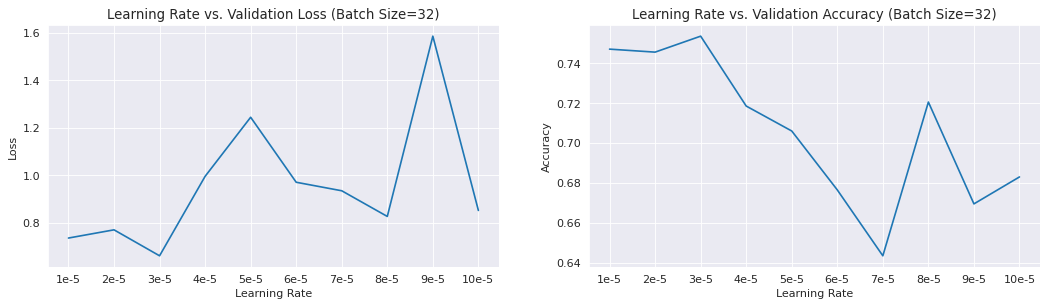

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16, 4), ncols=2, dpi=80)

sns.lineplot(x=lr_list, y=eval_results['loss'], ax=ax[0])
sns.lineplot(x=lr_list, y=eval_results['accuracy'], ax=ax[1])

# fig.suptitle('Learning Rate vs. Validation Performance (Batch Size=32)')
for i in range(2):
    ax[i].set_xlabel('Learning Rate')
    # ax.set_ylim([0, 1.7])
    ax[i].set_xticks([(i+1) * 1e-5 for i in range(10)])
    ax[i].xaxis.set_major_formatter(lambda y, p: f'{1e5*y:.0f}e-5')
#     ax[i].legend(loc='best')
    
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')

ax[0].set_title('Learning Rate vs. Validation Loss (Batch Size=32)')
ax[1].set_title('Learning Rate vs. Validation Accuracy (Batch Size=32)')
plt.show()

## Try see if batch size would influence the training outcome
### Split by Country Name Approach

In [25]:
train_index = [val_split for _, val_split in skf_train.split(X_train,y_train)] 
val_index = [val_split for _, val_split in skf_val.split(X_val,y_val)] 

test_result = run_test(X_train, y_train, X_val, y_val,
                       train_index, val_index,
                       class_weight = {0: 1., 1: 1.}, 
                       epochs=1, batch_size=1)
test_result

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 252ms/step - loss: 0.6942 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - TP: 1000.0000 - TN: 0.0000e+00 - FP: 1000.0000 - FN: 0.0000e+00


ZeroDivisionError: float division by zero

For the sake of running time, we will just look at the validation accuracy of the first fold. We obtained an accuracy of 0.5 by setting learning rate = 5e-5, and batch_size = 1. This is exactly the by-chance prediction accuracy. In previous experiment, we obtained a confidence interval of (68.90, 73.11) of the model accuracy when using batch_size=32. This performance drop is significant enough for us to conclude that the model failed to learn the features when using a mini batch when sample size is small. 

## Try see if adjusting learning rate would help increase accuracy when batch size is 1
### Split by Country Name Approach

In [28]:
train_index = [val_split for _, val_split in skf_train.split(X_train,y_train)] 
val_index = [val_split for _, val_split in skf_val.split(X_val,y_val)] 

test_result = run_test(X_train, y_train, X_val, y_val,
                       train_index, val_index,
                       class_weight = {0: 1., 1: 1.}, 
                       epochs=1, batch_size=1, lr=1e-6)
test_result

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 241ms/step - loss: 0.6354 - accuracy: 0.7410 - precision: 0.6928 - recall: 0.8660 - TP: 866.0000 - TN: 616.0000 - FP: 384.0000 - FN: 134.0000
[0.6354032754898071, 0.7409999966621399, 0.692799985408783, 0.8659999966621399, 866.0, 616.0, 384.0, 134.0, 0.7697777674521928, 0.8213333333333334, 0.616, 0.7040000000000001]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 243ms/step - loss: 0.8088 - accuracy: 0.7470 - precision: 0.6900 - recall: 0.8970 - TP: 897.0000 - TN: 597.0000 - FP: 403.0000 - FN: 103.0000
[0.8087695837020874, 0.746999979019165, 0.6899999976158142, 0.8970000147819519, 897.0, 597.0, 403.0, 103.0, 0.7800000040652846, 0.8528571428571429, 0.597, 0.7023529411764706]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.7657 - accuracy: 0.7295 - precision: 0.7015 - recall: 0.7990 - TP: 799.0000 - TN: 660.0000 - FP: 340.0000 - FN: 201.0000
[0.7656879425048828, 0.7294999957084656, 0.7014925479888916, 0.7990000247955322, 799.0, 660.0, 340.0, 201.0, 0.7470780907591091, 0.7665505226480837, 0.66, 0.709296077377754]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 241ms/step - loss: 0.7240 - accuracy: 0.7775 - precision: 0.7088 - recall: 0.9420 - TP: 942.0000 - TN: 613.0000 - FP: 387.0000 - FN: 58.0000
[0.7239514589309692, 0.7774999737739563, 0.7088035941123962, 0.9419999718666077, 942.0, 613.0, 387.0, 58.0, 0.8089308497669188, 0.9135618479880775, 0.613, 0.7336923997606223]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 255ms/step - loss: 0.6364 - accuracy: 0.7480 - precision: 0.7279 - recall: 0.7920 - TP: 792.0000 - TN: 704.0000 - FP: 296.0000 - FN: 208.0000
[0.6364432573318481, 0.7480000257492065, 0.7279411554336548, 0.7919999957084656, 792.0, 704.0, 296.0, 208.0, 0.7586206762626987, 0.7719298245614035, 0.704, 0.7364016736401674]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 0.7222 - accuracy: 0.7220 - precision: 0.6993 - recall: 0.7790 - TP: 779.0000 - TN: 665.0000 - FP: 335.0000 - FN: 221.0000
[0.7222388982772827, 0.722000002861023, 0.6992818713188171, 0.7789999842643738, 779.0, 665.0, 335.0, 221.0, 0.7369914806115468, 0.7505643340857788, 0.665, 0.7051961823966066]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 240ms/step - loss: 0.9101 - accuracy: 0.7230 - precision: 0.6591 - recall: 0.9240 - TP: 924.0000 - TN: 522.0000 - FP: 478.0000 - FN: 76.0000
[0.910067617893219, 0.7229999899864197, 0.6590585112571716, 0.9240000247955322, 924.0, 522.0, 478.0, 76.0, 0.7693588921377182, 0.8729096989966555, 0.522, 0.6533166458072591]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 244ms/step - loss: 0.7241 - accuracy: 0.7305 - precision: 0.6932 - recall: 0.8270 - TP: 827.0000 - TN: 634.0000 - FP: 366.0000 - FN: 173.0000
[0.7241113781929016, 0.7304999828338623, 0.6932104229927063, 0.8270000219345093, 827.0, 634.0, 366.0, 173.0, 0.7542179925591107, 0.7856257744733581, 0.634, 0.7017155506364139]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.8202 - accuracy: 0.7180 - precision: 0.6829 - recall: 0.8140 - TP: 814.0000 - TN: 622.0000 - FP: 378.0000 - FN: 186.0000
[0.8201977610588074, 0.7179999947547913, 0.6828858852386475, 0.8140000104904175, 814.0, 622.0, 378.0, 186.0, 0.7427007219909417, 0.7698019801980198, 0.622, 0.6880530973451328]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 237ms/step - loss: 0.9008 - accuracy: 0.7320 - precision: 0.6671 - recall: 0.9260 - TP: 926.0000 - TN: 538.0000 - FP: 462.0000 - FN: 74.0000
[0.9008121490478516, 0.7319999933242798, 0.6671469807624817, 0.9259999990463257, 926.0, 538.0, 462.0, 74.0, 0.7755443928016689, 0.8790849673202614, 0.538, 0.6674937965260547]


,loss,accuracy,precision,recall,TP,TN,FP,FN,f1,precision_neg,recall_neg,f1_neg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.764768,0.736850,0.692262,0.856600,856.600000,617.100000,382.900000,143.400000,0.764322,0.818422,0.617100,0.700152
std,0.096009,0.017583,0.019744,0.061982,61.982435,55.496647,55.496647,61.982435,0.021248,0.057534,0.055497,0.025770
min,0.635403,0.718000,0.659059,0.779000,779.000000,522.000000,296.000000,58.000000,0.736991,0.750564,0.522000,0.653317
25%,0.722667,0.724625,0.684664,0.802750,802.750000,601.000000,346.500000,82.750000,0.748863,0.770334,0.601000,0.691469
50%,0.744900,0.731250,0.693005,0.846500,846.500000,619.000000,381.000000,153.500000,0.763990,0.803480,0.619000,0.703176
75%,0.817341,0.745500,0.700940,0.917250,917.250000,653.500000,399.000000,197.250000,0.774103,0.867897,0.653500,0.708271
max,0.910068,0.777500,0.727941,0.942000,942.000000,704.000000,478.000000,221.000000,0.808931,0.913562,0.704000,0.736402
ci_lower,0.697120,0.724461,0.678350,0.812927,812.927215,577.997098,343.797098,99.727215,0.749351,0.777884,0.577997,0.681995
ci_upper,0.832416,0.749239,0.706174,0.900273,900.272785,656.202902,422.002902,187.072785,0.779293,0.858960,0.656203,0.718309


## Load Shuffled Data

In [6]:
# Load in data
train_count = 0  
val_count = 0  
train_label_counter = [0, 0]
val_label_counter = [0, 0]

train_label_count_max = 4e4 
val_label_count_max = 1e4 
total_train = 2 * train_label_count_max
total_val = 2 * val_label_count_max

X_train = []
y_train = []

X_val = []
y_val = []

for line in fs.open('s3://compressed-data-sample/shuffled_train.json'):
    if train_count >= total_train and val_count >= total_val:
        break
    json_file = json.loads(line)
    country = json_file['country']
    label =  int(json_file['country'] in PEACE_COUNTRY)
    
    if not country in MAJOR_COUNTRY:
        if train_label_counter[label] < train_label_count_max :
            sent = json_file['content_cleaned_shuffled']
            ids, msk = regular_encode(sent, tokenizer) # tokenize content_cleaned
            
            X_train.append({'input_ids': ids,'attention_mask':msk})
            y_train.append(label)
            train_count += 1
            train_label_counter[label] += 1
            if sum(train_label_counter) % 1e3 == 0:
                print('train', train_label_counter)
    else:
        if val_label_counter[label] < val_label_count_max :
            sent = json_file['content_cleaned_shuffled']
            ids, msk = regular_encode(sent, tokenizer) # tokenize content_cleaned
            
            X_val.append({'input_ids': ids,'attention_mask':msk})
            y_val.append(label)
            val_count += 1
            val_label_counter[label] += 1
            if sum(val_label_counter) % 1e3 == 0:
                print('val',  val_label_counter)
            

val [532, 468]
val [1065, 935]
val [1607, 1393]
val [2144, 1856]
val [2690, 2310]
train [240, 760]
val [3255, 2745]
val [3805, 3195]
val [4348, 3652]
val [4906, 4094]
val [5457, 4543]
train [481, 1519]
val [5984, 5016]
val [6519, 5481]
val [7059, 5941]
val [7638, 6362]
val [8191, 6809]
train [749, 2251]
val [8747, 7253]
val [9315, 7685]
val [9837, 8163]
val [10000, 9000]
train [1028, 2972]
val [10000, 10000]
train [1268, 3732]
train [1522, 4478]
train [1770, 5230]
train [2027, 5973]
train [2301, 6699]
train [2562, 7438]
train [2796, 8204]
train [3071, 8929]
train [3327, 9673]
train [3601, 10399]
train [3863, 11137]
train [4128, 11872]
train [4384, 12616]
train [4619, 13381]
train [4861, 14139]
train [5101, 14899]
train [5352, 15648]
train [5588, 16412]
train [5843, 17157]
train [6113, 17887]
train [6353, 18647]
train [6634, 19366]
train [6926, 20074]
train [7193, 20807]
train [7450, 21550]
train [7714, 22286]
train [7969, 23031]
train [8237, 23763]
train [8478, 24522]
train [8739, 2526

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_all = np.hstack([X_train, X_val])
y_all = np.hstack([y_train, y_val])

## Randomly split, train on shuffled
Train: 8K, Val: 2K

In [13]:
from sklearn.model_selection import train_test_split

# Throw out some data to make sample # same as split by country
_, train_index = train_test_split(np.array(range(len(X_all))),test_size=0.1, stratify=y_all)

X_all_sample, y_all_sample = X_all[train_index], y_all[train_index]

train_index, val_index = list(zip(*[train_test_split(np.array(range(len(X_all_sample))), 
                            test_size=0.2, stratify=y_all_sample) for i in range(10)]))

test_result = run_test(X_all_sample, y_all_sample, X_all_sample, y_all_sample, 
                       train_index, val_index, class_weight = {0: 1., 1: 1.}, epochs=1)
test_result

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 243ms/step - loss: 0.2497 - accuracy: 0.8935 - precision: 0.8594 - recall: 0.9410 - TP: 941.0000 - TN: 846.0000 - FP: 154.0000 - FN: 59.0000
[0.24974550306797028, 0.8934999704360962, 0.8593607544898987, 0.9409999847412109, 941.0, 846.0, 154.0, 59.0, 0.8983293617117518, 0.9348066298342541, 0.846, 0.8881889763779527]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 240ms/step - loss: 0.2183 - accuracy: 0.9180 - precision: 0.9130 - recall: 0.9240 - TP: 924.0000 - TN: 912.0000 - FP: 88.0000 - FN: 76.0000
[0.21827912330627441, 0.9179999828338623, 0.9130434989929199, 0.9240000247955322, 924.0, 912.0, 88.0, 76.0, 0.9184890883467274, 0.9230769230769231, 0.912, 0.9175050301810865]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 239ms/step - loss: 0.2354 - accuracy: 0.9035 - precision: 0.9316 - recall: 0.8710 - TP: 871.0000 - TN: 936.0000 - FP: 64.0000 - FN: 129.0000
[0.23537808656692505, 0.9035000205039978, 0.9315508008003235, 0.8709999918937683, 871.0, 936.0, 64.0, 129.0, 0.9002583929776822, 0.8788732394366198, 0.936, 0.9065375302663439]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 250ms/step - loss: 0.2229 - accuracy: 0.9155 - precision: 0.9022 - recall: 0.9320 - TP: 932.0000 - TN: 899.0000 - FP: 101.0000 - FN: 68.0000
[0.2229403406381607, 0.9154999852180481, 0.9022265076637268, 0.9319999814033508, 932.0, 899.0, 101.0, 68.0, 0.9168716005098024, 0.9296794208893485, 0.899, 0.9140823589222167]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 237ms/step - loss: 0.2048 - accuracy: 0.9235 - precision: 0.8918 - recall: 0.9640 - TP: 964.0000 - TN: 883.0000 - FP: 117.0000 - FN: 36.0000
[0.20475022494792938, 0.9235000014305115, 0.8917669057846069, 0.9639999866485596, 964.0, 883.0, 117.0, 36.0, 0.9264776613649478, 0.9608269858541894, 0.883, 0.9202709744658676]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.2255 - accuracy: 0.9135 - precision: 0.8949 - recall: 0.9370 - TP: 937.0000 - TN: 890.0000 - FP: 110.0000 - FN: 63.0000
[0.22545872628688812, 0.9135000109672546, 0.8949379324913025, 0.9369999766349792, 937.0, 890.0, 110.0, 63.0, 0.9154860736890864, 0.9338929695697796, 0.89, 0.9114183307731695]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 241ms/step - loss: 0.2467 - accuracy: 0.9040 - precision: 0.9262 - recall: 0.8780 - TP: 878.0000 - TN: 930.0000 - FP: 70.0000 - FN: 122.0000
[0.2467280775308609, 0.9039999842643738, 0.9261603355407715, 0.878000020980835, 878.0, 930.0, 70.0, 122.0, 0.9014373817682054, 0.8840304182509505, 0.93, 0.9064327485380117]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 245ms/step - loss: 0.2538 - accuracy: 0.8955 - precision: 0.8920 - recall: 0.9000 - TP: 900.0000 - TN: 891.0000 - FP: 109.0000 - FN: 100.0000
[0.2537692189216614, 0.8955000042915344, 0.8919722437858582, 0.8999999761581421, 900.0, 891.0, 109.0, 100.0, 0.8959681285305682, 0.8990918264379415, 0.891, 0.8950276243093923]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 240ms/step - loss: 0.2496 - accuracy: 0.9035 - precision: 0.8991 - recall: 0.9090 - TP: 909.0000 - TN: 898.0000 - FP: 102.0000 - FN: 91.0000
[0.2495790272951126, 0.9035000205039978, 0.8991097807884216, 0.9089999794960022, 909.0, 898.0, 102.0, 91.0, 0.9040278308909374, 0.9079878665318504, 0.898, 0.9029663147310206]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.2549 - accuracy: 0.9035 - precision: 0.9147 - recall: 0.8900 - TP: 890.0000 - TN: 917.0000 - FP: 83.0000 - FN: 110.0000
[0.2549424171447754, 0.9035000205039978, 0.9146968126296997, 0.8899999856948853, 890.0, 917.0, 83.0, 110.0, 0.9021794141945089, 0.8928919182083739, 0.917, 0.9047853971386286]


,loss,accuracy,precision,recall,TP,TN,FP,FN,f1,precision_neg,recall_neg,f1_neg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.236157,0.907400,0.902483,0.914600,914.600000,900.200000,99.800000,85.400000,0.907952,0.914516,0.900200,0.906722
std,0.017434,0.009812,0.020601,0.030038,30.037754,25.862027,25.862027,30.037754,0.010420,0.026211,0.025862,0.009856
min,0.204750,0.893500,0.859361,0.871000,871.000000,846.000000,64.000000,36.000000,0.895968,0.878873,0.846000,0.888189
25%,0.223570,0.903500,0.892714,0.892500,892.500000,890.250000,84.250000,64.250000,0.900553,0.894442,0.890250,0.903421
50%,0.241053,0.903750,0.900668,0.916500,916.500000,898.500000,101.500000,83.500000,0.903104,0.915532,0.898500,0.906485
75%,0.249704,0.915000,0.914283,0.935750,935.750000,915.750000,109.750000,107.500000,0.916525,0.932840,0.915750,0.913416
max,0.254942,0.923500,0.931551,0.964000,964.000000,936.000000,154.000000,129.000000,0.926478,0.960827,0.936000,0.920271
ci_lower,0.223873,0.900487,0.887967,0.893435,893.435417,881.977632,81.577632,64.235417,0.900611,0.896048,0.881978,0.899777
ci_upper,0.248441,0.914313,0.916998,0.935765,935.764583,918.422368,118.022368,106.564583,0.915294,0.932984,0.918422,0.913666


## Split by country, train on shuffled
Train: 8K, Val: 2K

In [14]:
train_index = [val_split for _, val_split in skf_train.split(X_train,y_train)] 
val_index = [val_split for _, val_split in skf_val.split(X_val,y_val)] 

test_result = run_test(X_train, y_train, X_val, y_val,
                       train_index, val_index, class_weight = {0: 1., 1: 1.}, epochs=1)
test_result

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 245ms/step - loss: 0.7161 - accuracy: 0.7070 - precision: 0.6791 - recall: 0.7850 - TP: 785.0000 - TN: 629.0000 - FP: 371.0000 - FN: 215.0000
[0.7161105871200562, 0.7070000171661377, 0.6790657639503479, 0.7850000262260437, 785.0, 629.0, 371.0, 215.0, 0.728200393844333, 0.745260663507109, 0.629, 0.6822125813449024]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 243ms/step - loss: 0.7216 - accuracy: 0.6885 - precision: 0.6626 - recall: 0.7680 - TP: 768.0000 - TN: 609.0000 - FP: 391.0000 - FN: 232.0000
[0.7215924859046936, 0.6884999871253967, 0.6626402139663696, 0.7680000066757202, 768.0, 609.0, 391.0, 232.0, 0.7114404885406733, 0.7241379310344828, 0.609, 0.661596958174905]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 240ms/step - loss: 0.8174 - accuracy: 0.6665 - precision: 0.6344 - recall: 0.7860 - TP: 786.0000 - TN: 547.0000 - FP: 453.0000 - FN: 214.0000
[0.8173850178718567, 0.6664999723434448, 0.6343825459480286, 0.7860000133514404, 786.0, 547.0, 453.0, 214.0, 0.7020991440939578, 0.7187910643889619, 0.547, 0.6212379329926179]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 237ms/step - loss: 0.7499 - accuracy: 0.6980 - precision: 0.6658 - recall: 0.7950 - TP: 795.0000 - TN: 601.0000 - FP: 399.0000 - FN: 205.0000
[0.7499043941497803, 0.6980000138282776, 0.6658291220664978, 0.7950000166893005, 795.0, 601.0, 399.0, 205.0, 0.724703730384139, 0.7456575682382134, 0.601, 0.6655592469545958]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 251ms/step - loss: 0.6349 - accuracy: 0.6490 - precision: 0.6215 - recall: 0.7620 - TP: 762.0000 - TN: 536.0000 - FP: 464.0000 - FN: 238.0000
[0.6349123120307922, 0.6489999890327454, 0.6215334534645081, 0.7620000243186951, 762.0, 536.0, 464.0, 238.0, 0.6846361353159119, 0.6925064599483204, 0.536, 0.6042841037204059]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 242ms/step - loss: 0.8718 - accuracy: 0.6830 - precision: 0.6195 - recall: 0.9490 - TP: 949.0000 - TN: 417.0000 - FP: 583.0000 - FN: 51.0000
[0.871759831905365, 0.6830000281333923, 0.6194517016410828, 0.9490000009536743, 949.0, 417.0, 583.0, 51.0, 0.7496050588942219, 0.8910256410256411, 0.417, 0.5681198910081744]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 1.0394 - accuracy: 0.6940 - precision: 0.6414 - recall: 0.8800 - TP: 880.0000 - TN: 508.0000 - FP: 492.0000 - FN: 120.0000
[1.0393527746200562, 0.6940000057220459, 0.6413994431495667, 0.8799999952316284, 880.0, 508.0, 492.0, 120.0, 0.7419898978190188, 0.8089171974522293, 0.508, 0.624078624078624]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 15s 238ms/step - loss: 0.8191 - accuracy: 0.7160 - precision: 0.6598 - recall: 0.8920 - TP: 892.0000 - TN: 540.0000 - FP: 460.0000 - FN: 108.0000
[0.8190885186195374, 0.7160000205039978, 0.6597633361816406, 0.8920000195503235, 892.0, 540.0, 460.0, 108.0, 0.7585034233457736, 0.8333333333333334, 0.54, 0.6553398058252428]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 248ms/step - loss: 0.9214 - accuracy: 0.6615 - precision: 0.6454 - recall: 0.7170 - TP: 717.0000 - TN: 606.0000 - FP: 394.0000 - FN: 283.0000
[0.9214298129081726, 0.6614999771118164, 0.64536452293396, 0.7170000076293945, 717.0, 606.0, 394.0, 283.0, 0.6792989064036287, 0.6816647919010124, 0.606, 0.6416093170989943]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 16s 255ms/step - loss: 0.7422 - accuracy: 0.7085 - precision: 0.6480 - recall: 0.9130 - TP: 913.0000 - TN: 504.0000 - FP: 496.0000 - FN: 87.0000
[0.7421846985816956, 0.7085000276565552, 0.6479772925376892, 0.9129999876022339, 913.0, 504.0, 496.0, 87.0, 0.7579908658252977, 0.8527918781725888, 0.504, 0.6335637963544941]


,loss,accuracy,precision,recall,TP,TN,FP,FN,f1,precision_neg,recall_neg,f1_neg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.803372,0.687200,0.647741,0.824700,824.700000,549.700000,450.300000,175.300000,0.723847,0.769409,0.549700,0.635760
std,0.117392,0.022125,0.019398,0.077126,77.126231,64.405055,64.405055,77.126231,0.028922,0.072082,0.064405,0.033415
min,0.634912,0.649000,0.619452,0.717000,717.000000,417.000000,371.000000,51.000000,0.679299,0.681665,0.417000,0.568120
25%,0.726741,0.670625,0.636137,0.772250,772.250000,515.000000,395.250000,111.000000,0.704434,0.720128,0.515000,0.621948
50%,0.783645,0.691250,0.646671,0.790500,790.500000,543.500000,456.500000,209.500000,0.726452,0.745459,0.543500,0.637587
75%,0.858592,0.704750,0.661921,0.889000,889.000000,604.750000,485.000000,227.750000,0.747701,0.827229,0.604750,0.660033
max,1.039353,0.716000,0.679066,0.949000,949.000000,629.000000,583.000000,283.000000,0.758503,0.891026,0.629000,0.682213
ci_lower,0.720657,0.671611,0.634073,0.770357,770.356906,504.320239,404.920239,120.956906,0.703469,0.718620,0.504320,0.612216
ci_upper,0.886087,0.702789,0.661408,0.879043,879.043094,595.079761,495.679761,229.643094,0.744225,0.820198,0.595080,0.659304


In [16]:
train_index = [val_split for _, val_split in skf_train.split(X_train,y_train)] 
val_index = [val_split for _, val_split in skf_val.split(X_val,y_val)] 

test_result = run_test(X_train, y_train, X_val, y_val,
                       train_index, val_index, class_weight = {0: 1., 1: 1.}, epochs=2, lr=5e-5)
test_result

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
250/250 [==============================] - 202s 809ms/step - loss: 0.3232 - accuracy: 0.8629 - precision: 0.8432 - recall: 0.8915 - TP: 3566.0000 - TN: 3337.0000 - FP: 663.0000 - FN: 434.0000
Epoch 2/2
63/63 [==============================] - 15s 240ms/step - loss: 1.3473 - accuracy: 0.6765 - precision: 0.6210 - recall: 0.9060 - TP: 906.0000 - TN: 447.0000 - FP: 553.0000 - FN: 94.0000
[1.3473315238952637, 0.6765000224113464, 0.6209732890129089, 0.906000018119812, 906.0, 447.0, 553.0, 94.0, 0.736884932394846, 0.8262476894639557, 0.447, 0.5801427644386762]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
 76/250 [========>.....................] - ETA: 2:09 - loss: 0.4490 - accuracy: 0.7788 - precision: 0.7554 - recall: 0.8135 - TP: 973.0000 - TN: 921.0000 - FP: 315.0000 - FN: 223.0000

KeyboardInterrupt: 

## Split by country, all data in one fold
Train: 80K, Val: 20K

In [21]:
tf.keras.backend.clear_session()
model = get_model()
        
train_input1 = np.vstack([x['input_ids'] for x in X_train])
train_input2 = np.vstack([x['attention_mask'] for x in X_train])
model.fit(x=[train_input1, train_input2], 
          y=np.asarray(y_train),
          epochs = 1,
          class_weight={0: 1., 1: 1.})

eval_input1 = np.vstack([x['input_ids'] for x in X_val])
eval_input2 = np.vstack([x['attention_mask'] for x in X_val])
er = model.evaluate(x=[eval_input1, eval_input2], 
                    y=np.asarray(y_val), return_dict=True)
f1 = 2*er['precision']*er['recall'] / (er['precision']+er['recall'])

precision_neg = er['TN'] / (er['TN'] + er['FN'])
recall_neg = er['TN'] / (er['TN'] + er['FP'])
f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg)

er = list(er.values())
er += [f1, precision_neg, recall_neg, f1_neg]
pd.DataFrame(data = er, 
             index = model.metrics_names + ['f1', 'precision_neg', 'recall_neg', 'f1_neg'])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


625/625 [==============================] - 155s 247ms/step - loss: 1.1408 - accuracy: 0.6951 - precision: 0.6407 - recall: 0.8881 - TP: 8881.0000 - TN: 5020.0000 - FP: 4980.0000 - FN: 1119.0000


,0
loss,1.140769
accuracy,0.695050
precision,0.640719
recall,0.888100
TP,8881.000000
TN,5020.000000
FP,4980.000000
FN,1119.000000
f1,0.744395
precision_neg,0.817723
